## 1. Environment Setup
This section sets up the required libraries and defines the custom environment with a continuous action space suitable for PPO, SAC, and DQN.

In [1]:
pip install gym numpy stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

### Environment Definition (Continuous Action Space)

In [3]:
class StrawberryEnv(gym.Env):
    def __init__(self):
        super().__init__()

        # Define the observation space:
        # [temperature (°C), humidity (%), light (lx), growth stage (1-3), hours passed in current stage]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 1, 0], dtype=np.float32),
            high=np.array([40, 100, 10000, 3, 24], dtype=np.float32),
            dtype=np.float32
        )

        # Action space: continuous adjustments for [temperature, humidity, light]
        # Each element ∈ [-1.0, 1.0] and will be scaled inside _apply_action()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(3,), dtype=np.float32)
        self.rewards = []
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Initialize state variables with realistic starting values
        self.temp = np.round(np.random.uniform(18, 25), 1)
        self.humidity = np.round(np.random.uniform(40, 90), 1)
        self.light = np.round(np.random.uniform(1500, 3500), 1)
        self.stage = 1            # Initial growth stage
        self.hours_in_stage = 0   # Hours passed in the current stage
        self.days_in_stage = 0    # Days passed in the current stage
        self.total_days = 0       # Total number of simulated days
        self.done = False
        self.rewards = []         # Reset reward history
        return self._get_obs(), {}

    def _get_obs(self):
        # Return current observation (state) as a rounded float32 array
        return np.round(np.array([
            self.temp, self.humidity, self.light, self.stage, self.hours_in_stage
        ]), 1).astype(np.float32)

    def step(self, action):
        # Convert action from shape (3,1) to (3,)
        action = np.squeeze(action)

        # Apply scaled environmental changes based on the action
        self._apply_action(action)

        # Compute reward and check if the episode is done
        reward, done = self._compute_reward()
        self.rewards.append(reward)
        obs = self._get_obs()
        return obs, reward, done, False, {}

    def _apply_action(self, action):
        # Apply the action to the environment by scaling it:
        # Temp: ±2°C, Humidity: ±7%, Light: ±100lx
        self.temp += action[0] * 2.0
        self.humidity += action[1] * 7.0
        self.light += action[2] * 100.0

    def _compute_reward(self):
        # Define optimal ranges for each growth stage
        # Format: (temp_min, temp_max, humidity_min, humidity_max, light_min, light_max)
        optimal_ranges = {
            1: (22, 25, 70, 80, 1500, 2500),
            2: (20, 23, 60, 70, 2500, 3500),
            3: (18, 22, 50, 60, 2500, 3500),
        }

        # Define duration (in days) for each stage
        stage_durations = {1: 9, 2: 11, 3: 28}


        # If all stages are completed, end the episode
        if self.stage > 3:
            return 0, True


        opt_t_min, opt_t_max, opt_h_min, opt_h_max, opt_l_min, opt_l_max = optimal_ranges[self.stage]
        reward = 0

        # Temperature reward
        if opt_t_min <= self.temp <= opt_t_max:
            reward += 5
        elif abs(self.temp - (opt_t_min + opt_t_max) / 2) <= 3:
            reward += 2
        else:
            reward -= 0.2

        # Humidity reward
        if opt_h_min <= self.humidity <= opt_h_max:
            reward += 5
        elif abs(self.humidity - (opt_h_min + opt_h_max) / 2) <= 10:
            reward += 2
        else:
            reward -= 0.2

        # Light reward
        if opt_l_min <= self.light <= opt_l_max:
            reward += 5
        elif abs(self.light - (opt_l_min + opt_l_max) / 2) <= 500:
            reward += 2
        else:
            reward -= 0.2

        # Progress one day: in 6-hour units
        self.hours_in_stage += 6
        if self.hours_in_stage >= 24:
            self.days_in_stage += 1
            self.total_days += 1
            self.hours_in_stage = 0

        # Move to next stage if current stage duration is fulfilled
        if self.days_in_stage >= stage_durations.get(self.stage, 0):
            self.stage += 1
            self.days_in_stage = 0
            self.hours_in_stage = 0
            if self.stage > 3:
                return reward, True

        # Clip reward to prevent extreme values
        reward = np.clip(reward, -10, 30)
        return reward, False

    def get_reward_log(self):
        return self.rewards


In [4]:
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env

# 2. PPO

In [ ]:
from stable_baselines3 import PPO

# Set directory to store training logs (used for reward tracking)
log_dir = "./ppo_logs/"
os.makedirs(log_dir, exist_ok=True)

# Initialize the custom environment
env = StrawberryEnv()

# Verify that the environment follows Gym API standards
check_env(env)
env = Monitor(env, log_dir)

model = PPO("MlpPolicy",        # Use a Multi-Layer Perceptron (MLP) policy network
            env,                # The environment to train on
            verbose=1,          # Print training logs to the console
            learning_rate=3e-4, # Common default learning rate for PPO
            ent_coef=0.01)      # Entropy coefficient to encourage exploration

# Train the PPO agent for 500,000 time steps
model.learn(total_timesteps=500_000)
model.save("strawberry_ppo")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
|    loss                 | 1.41e+03     |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.000948    |
|    std                  | 1            |
|    value_loss           | 2.5e+03      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 192         |
|    ep_rew_mean          | 567         |
| time/                   |             |
|    fps                  | 709         |
|    iterations           | 19          |
|    time_elapsed         | 54          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.005261409 |
|    clip_fraction        | 0.021       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.00198     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.04e+

In [ ]:
import matplotlib.pyplot as plt

# load the trained PPO model
model = PPO.load("strawberry_ppo")

# evaluate env
env = StrawberryEnv()

episode_rewards = []
episode_actions = []

num_episodes = 100

for _ in range(num_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    episode_action_log = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        episode_action_log.append(action)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    episode_rewards.append(total_reward)
    episode_actions.append(np.mean(np.squeeze(episode_action_log), axis=0))  # record average action

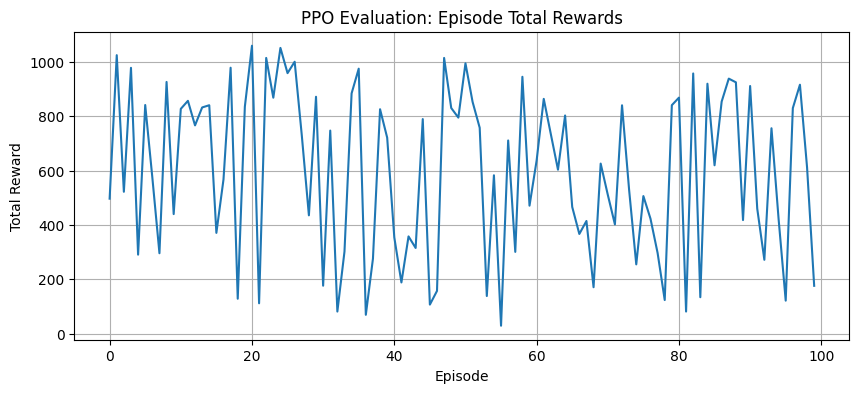

In [ ]:
# cumulative PPO reward graph
plt.figure(figsize=(10, 4))
plt.plot(episode_rewards)
plt.title("PPO Evaluation: Episode Total Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

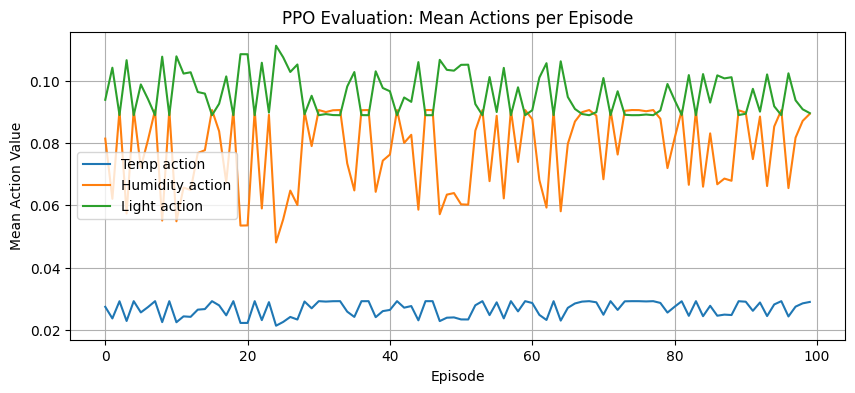

In [ ]:
# action graph (average action per episode)
episode_actions = np.array(episode_actions)

plt.figure(figsize=(10, 4))
plt.plot(episode_actions[:, 0], label="Temp action")
plt.plot(episode_actions[:, 1], label="Humidity action")
plt.plot(episode_actions[:, 2], label="Light action")
plt.title("PPO Evaluation: Mean Actions per Episode")
plt.xlabel("Episode")
plt.ylabel("Mean Action Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# load the PPO model
ppo_model = PPO.load("strawberry_ppo")

# Generalization env
class GeneralizationTestEnv(StrawberryEnv):
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.temp = np.round(np.random.uniform(15, 30), 1)
        self.humidity = np.round(np.random.uniform(30, 90), 1)
        self.light = np.round(np.random.uniform(1000, 4000), 1)
        return self._get_obs(), {}

# evaluate
generalization_successes = 0
test_episodes = 100

for _ in range(test_episodes):
    env = GeneralizationTestEnv()
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    if total_reward > 0:
        generalization_successes += 1

print(f"[Generalization Test] PPO Success Rate: {generalization_successes} / {test_episodes} = {generalization_successes}%")

[Generalization Test] PPO Success Rate: 92 / 100 = 92%


# 3. SAC

In [ ]:
from stable_baselines3 import SAC

# log directory
log_dir = "./sac_logs/"
os.makedirs(log_dir, exist_ok=True)

# prepare env
env = StrawberryEnv()
check_env(env)
env = Monitor(env, log_dir)

# SAC model configuration (enhanced exploration + training efficiency)
model = SAC(
    "MlpPolicy",        # Use a Multi-Layer Perceptron for the policy network
    env,                # Environment to train on
    verbose=1,          # Output training logs to console
    learning_rate=3e-4, # Commonly used learning rate for stable performance
    ent_coef="auto",    # Automatically tune entropy coefficient to balance exploration
    train_freq=1,       # Train the model every time step
    gradient_steps=1,   # Number of gradient steps to take at each training update
    batch_size=64,      # Number of samples per training batch
    learning_starts=1000, # Start training after 1000 steps to fill buffer
    buffer_size=50000   # Replay buffer size for experience replay
)

# Train the SAC agent for 500,000 time steps
model.learn(total_timesteps=500_000)

# save
model.save("strawberry_sac")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
|    n_updates       | 225559   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 192      |
|    ep_rew_mean     | 293      |
| time/              |          |
|    episodes        | 1184     |
|    fps             | 45       |
|    time_elapsed    | 4960     |
|    total_timesteps | 227328   |
| train/             |          |
|    actor_loss      | -292     |
|    critic_loss     | 3.67e+03 |
|    ent_coef        | 0.351    |
|    ent_coef_loss   | -0.325   |
|    learning_rate   | 0.0003   |
|    n_updates       | 226327   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 192      |
|    ep_rew_mean     | 309      |
| time/              |          |
|    episodes        | 1188     |
|    fps             | 45       |
|    time_elapsed    | 4979     |
|    total_timesteps | 228096   |
| train/    

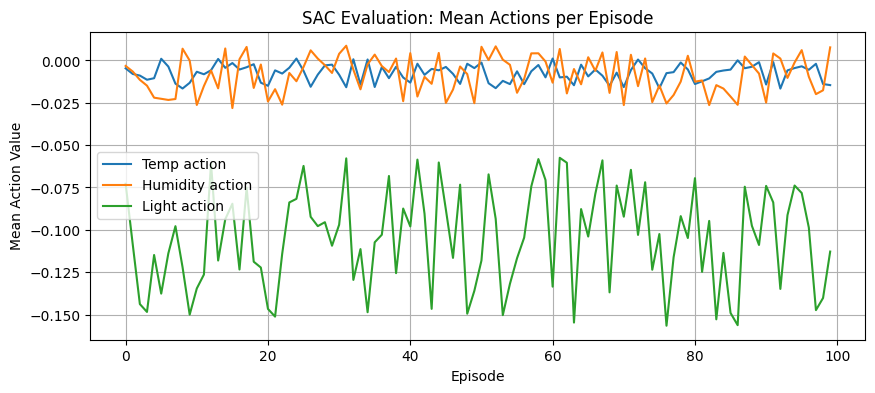

In [ ]:
# load the model
model = SAC.load("strawberry_sac")
env = StrawberryEnv()

# evaluate loop
sac_episode_rewards = []
sac_episode_actions = []

num_episodes = 100

for _ in range(num_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    episode_action_log = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        episode_action_log.append(np.squeeze(action))  # Explicitly squeeze to 1D
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    sac_episode_rewards.append(total_reward)

    # record average action
    if len(episode_action_log) > 0:
        sac_episode_actions.append(np.mean(episode_action_log, axis=0))
    else:
        sac_episode_actions.append(np.array([0.0, 0.0, 0.0]))  # fallback

# translate to numpy
sac_episode_actions = np.array(sac_episode_actions)

# visualization

plt.figure(figsize=(10, 4))
plt.plot(sac_episode_actions[:, 0], label="Temp action")
plt.plot(sac_episode_actions[:, 1], label="Humidity action")
plt.plot(sac_episode_actions[:, 2], label="Light action")
plt.title("SAC Evaluation: Mean Actions per Episode")
plt.xlabel("Episode")
plt.ylabel("Mean Action Value")
plt.legend()
plt.grid(True)
plt.show()


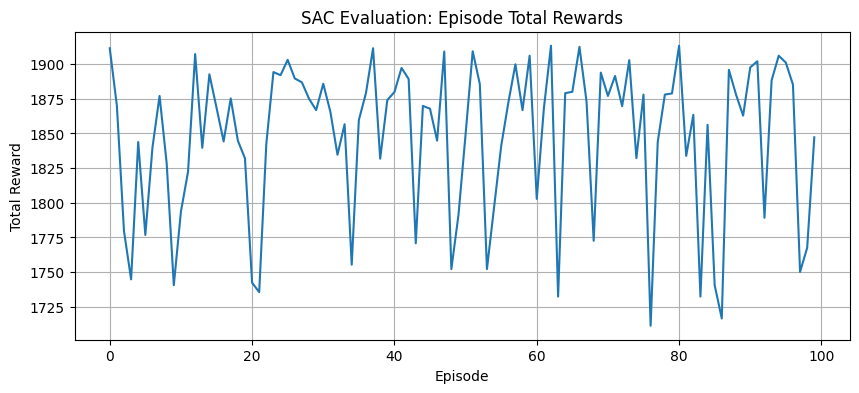

In [ ]:
# SAC cumulative reward graph
plt.figure(figsize=(10, 4))
plt.plot(sac_episode_rewards)
plt.title("SAC Evaluation: Episode Total Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [ ]:
# Load the trained sac model
sac_model = SAC.load("strawberry_sac")

# Generalization env
class GeneralizationTestEnv(StrawberryEnv):
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.temp = np.round(np.random.uniform(15, 30), 1)
        self.humidity = np.round(np.random.uniform(30, 90), 1)
        self.light = np.round(np.random.uniform(1000, 4000), 1)
        return self._get_obs(), {}

# Generalization evaluate
sac_generalization_successes = 0
test_episodes = 100

for _ in range(test_episodes):
    env = GeneralizationTestEnv()
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = sac_model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    if total_reward > 0:
        sac_generalization_successes += 1

print(f"[Generalization Test] SAC Success Rate: {sac_generalization_successes} / {test_episodes} = {sac_generalization_successes}%")

[Generalization Test] SAC Success Rate: 100 / 100 = 100%


## 4. Reward Comparison: PPO vs SAC

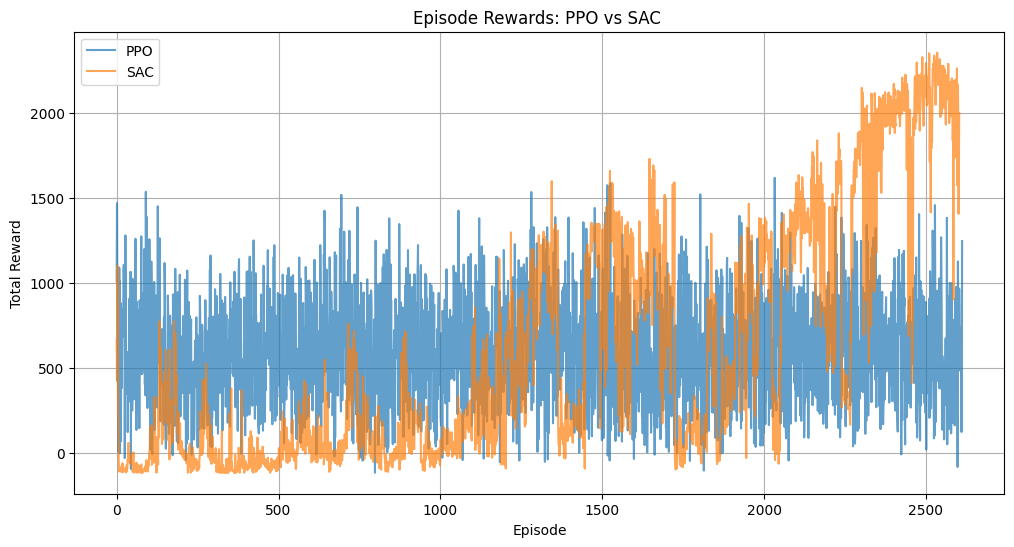

In [ ]:
import pandas as pd

ppo_rewards = pd.read_csv("./ppo_logs/monitor.csv", skiprows=1)["r"]
sac_rewards = pd.read_csv("./sac_logs/monitor.csv", skiprows=1)["r"]

plt.figure(figsize=(12, 6))
plt.plot(ppo_rewards, label="PPO", alpha=0.7)
plt.plot(sac_rewards, label="SAC", alpha=0.7)
plt.title("Episode Rewards: PPO vs SAC ")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()


# 5. + DQN (fit for Discrete space)

In [10]:
class DiscreteActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

        # Define a discrete action space with 27 possible actions
        # Each action represents a combination of adjustments to [temperature, humidity, light]
        self.action_space = spaces.Discrete(27)

        # Discrete scaling options:
        self._scales = [-1.0, 0.0, 1.0]
        self._delta_temp = 2.0      # Temperature scale
        self._delta_humidity = 7.0  # Humidity scale
        self._delta_light = 100.0    # Lighting scale

    def action(self, action):
        # Decode the discrete action (0–26) into 3 control values
        a = action // 9
        b = (action % 9) // 3
        c = action % 3

        # Apply scaling to get the actual adjustment values
        decoded = np.array([
            self._scales[a] * self._delta_temp,
            self._scales[b] * self._delta_humidity,
            self._scales[c] * self._delta_light
        ], dtype=np.float32)
        return decoded


    def step(self, action):
        # Convert discrete action into continuous adjustments and pass to base environment
        obs, reward, done, truncated, info = self.env.step(self.action(action))
        return obs, float(reward), done, truncated, info


In [11]:
# DQN
from stable_baselines3 import DQN

# Create log directory
dqn_log_dir = "./dqn_logs/"
os.makedirs(dqn_log_dir, exist_ok=True)

# Wrap the environment for DQN: apply DiscreteActionWrapper and Monitor for logging
dqn_env = DiscreteActionWrapper(StrawberryEnv())
check_env(dqn_env)
dqn_env = Monitor(dqn_env, dqn_log_dir)

# Initialize DQN model
model = DQN("MlpPolicy", dqn_env, verbose=1, learning_rate=1e-3, buffer_size=50000)

# Train the model
model.learn(total_timesteps=500_000)

# Save the trained model
model.save("strawberry_dqn")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.31e+03 |
|    n_updates        | 61030    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | -49      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1276     |
|    fps              | 1401     |
|    time_elapsed     | 174      |
|    total_timesteps  | 244992   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.04e+04 |
|    n_updates        | 61222    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 192      |
|    ep_rew_mean      | -49.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1280     |
|    fps           

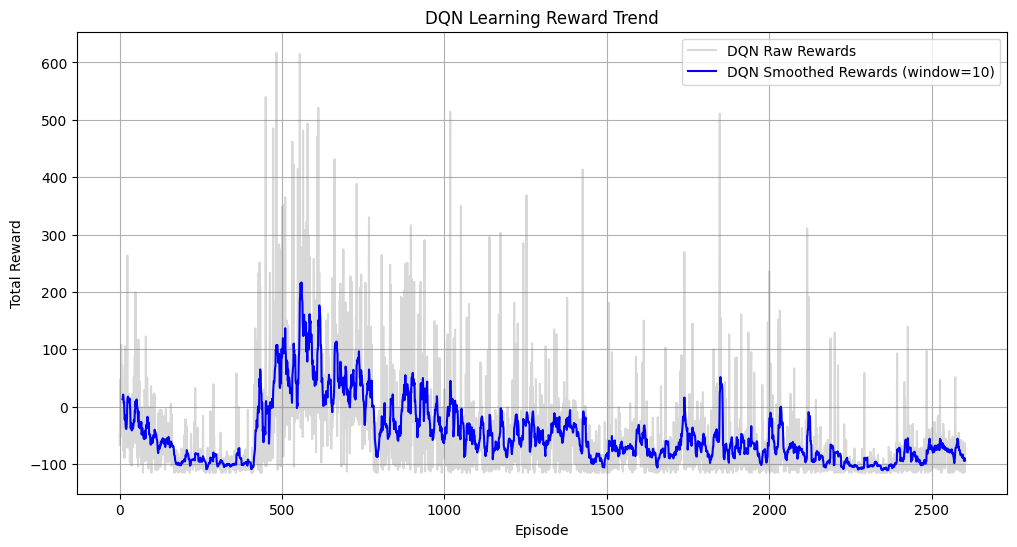

In [13]:
from stable_baselines3.common.results_plotter import load_results
import matplotlib.pyplot as plt

# loaded DQN log
results = load_results(dqn_log_dir)
raw_rewards = results['r']
smoothed_rewards = raw_rewards.rolling(window=10).mean()

# visualization
plt.figure(figsize=(12, 6))
plt.plot(raw_rewards, alpha=0.3, label='DQN Raw Rewards', color='gray')
plt.plot(smoothed_rewards, label='DQN Smoothed Rewards (window=10)', color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Learning Reward Trend")
plt.legend()
plt.grid(True)
plt.show()

# 6. Result

- PPO: Quickly stabilizes with relatively less exploration
→ Strong initial performance, commonly used choice

- SAC: Actively explores, slower convergence
→ Potential for more flexible long-term policies
- DQN : not suitable for the continuous environment, resulting in low and unstable performance even after discretization.

- Conclusion:
PPO is faster and more stable,
while SAC is more flexible but requires longer training time.